# Предсказание дубликатов среди наименований различных компаний

## Настройка и импорты

In [6]:
import unicodedata

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import translators as ts
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from wordcloud import WordCloud

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
np.random.seed(42)
torch.manual_seed(42)

## Смотрим на данные

In [9]:
df = pd.read_csv("../../data/train.csv")

df.sample(5)

,pair_id,name_1,name_2,is_duplicate
313708,313709,Ups De San Jose Sociedad Anonima,Inversionistas Y Distribuidores Sociedad Anoni...,0
83169,83170,"Rubchem India Pvt., Ltd.",Chemline India Ltd.,0
64665,64666,"Kwick Soft Solutions Pvt., Ltd.",Glideway Door Solutions,0
386982,386983,Ambrolink Trading,Stitchline Trading Llc,0
279256,279257,K Line Logistics (Usa.) Inc.,Shanghai Licang Logistics Co.,0


In [7]:
df[df["is_duplicate"] == 1].sample(5)

,pair_id,name_1,name_2,is_duplicate
409819,409820,Synthomer Llc,"Shanghai Synthomer Chemicals Co., Ltd.",1
132790,132791,"Bridgestone (Tianjin) Tire Co., Ltd.",Bridgestone Tire,1
269855,269856,Daewoo International Corp.,Fc Daewoo Textile Llc,1
474783,474784,Bridgestone International Group,Bridgestone Do Brasil Industria & Comercio Ltda,1
256040,256041,Exxonmobil Servicios Petroleros Mexico Sa De Cv,Exxonmobil Quimica Ltda,1


In [8]:
len(df)

497819

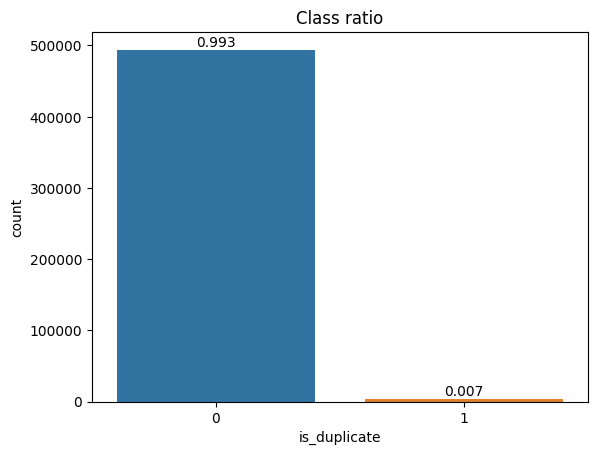

In [ ]:
fig, ax = plt.subplots()
ax = sns.countplot(x=df['is_duplicate'])

ax.bar_label(container=ax.containers[0],
             labels=df['is_duplicate'].value_counts(normalize=True).values.round(3))
ax.set_title('Class ratio');

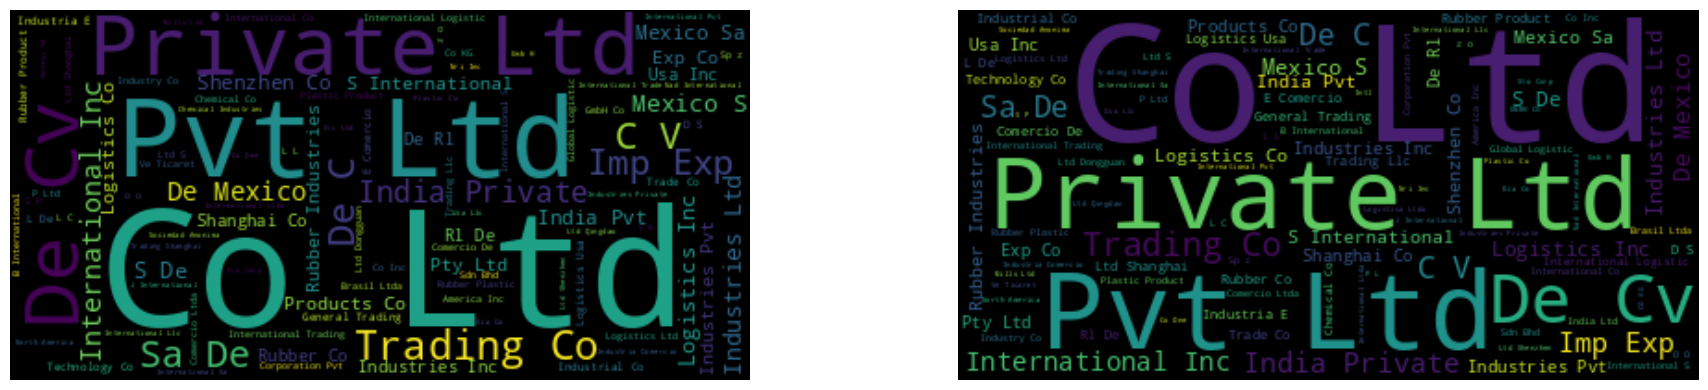

In [ ]:
text1 = " ".join(trade_name for trade_name in df.name_1)
text2 = " ".join(trade_name for trade_name in df.name_2)

wordcloud1 = WordCloud(max_words=100).generate(text1)
wordcloud2 = WordCloud(max_words=100).generate(text2)
store_wordclow = [wordcloud1, wordcloud2]

cols, rows = 2, 1

plt.figure(figsize=(20, 4*rows))
for i in range(1, 3):
    plt.subplot(rows, cols, i)
    plt.imshow(store_wordclow[i-1], interpolation='bilinear')
    plt.axis('off')

plt.tight_layout()
plt.show()

Видно, что в нейминге превалируют сущности, имеющие отношение к бизнесу и законодательству: Pvt, Ltd, Co, Trading Co, Inc, Sa De. Также видно, что данные включают в себя и международные компании из Китая, Индии, Мексики и т.д. 

## Подготовка данных

Есть много не английских названий, требующих перевода. Соответственно, задачу можно решать по-разному.

### Подход № 1 
Без перевода, но конвертировать символы, присущие другому языку, в латинский эквивалент

In [9]:
def convert_str(col):
    # Convert unicode characters
    col = unicodedata.normalize("NFD", col).encode("ascii", "ignore")
    col = col.decode("UTF-8")

    col = col.lower()

    return col

In [10]:
# Example
example = df.iloc[999]["name_1"]
example

'MOL Magyar Olaj- es Gazipari Nyilvanosan Mukodo Reszvenytarsasag (BUSE:MOL) - MOL Magyar Olaj és Gázipari Nyilvánosan Működő Részvénytársaság'

In [11]:
convert_str(example)

'mol magyar olaj- es gazipari nyilvanosan mukodo reszvenytarsasag (buse:mol) - mol magyar olaj es gazipari nyilvanosan mukodo reszvenytarsasag'

In [12]:
df["name_1_cvrt"] = df["name_1"].apply(convert_str)
df["name_2_cvrt"] = df["name_2"].apply(convert_str)

In [13]:
df = df[["name_1", "name_2", "name_1_cvrt", "name_2_cvrt", "is_duplicate"]]

In [14]:
df.sample(5)

,name_1,name_2,name_1_cvrt,name_2_cvrt,is_duplicate
65923,"Kohyei Polymers (India) Pvt., Ltd.",Polyone,"kohyei polymers (india) pvt., ltd.",polyone,0
407571,All Rubber (Pty) Ltd.,Euroma Rubber Industries Sdn Bhd,all rubber (pty) ltd.,euroma rubber industries sdn bhd,0
128876,Moras Chemicals India Private Ltd.,G.P (Private) Ltd.,moras chemicals india private ltd.,g.p (private) ltd.,0
267158,Iris Products S.A.De C.V.,"Wing Hing Metal Products Co., Ltd. In Dongguan",iris products s.a.de c.v.,"wing hing metal products co., ltd. in dongguan",0
399538,Coim S.p.A.,W. Quandt Gmbh & Co. Kg,coim s.p.a.,w. quandt gmbh & co. kg,0


### Подход № 2
Автоматический перевод наименований компаний с помощью Google API. <br>

Так можно было бы отлавливать похожие названия компания, сравнивания международные компании, с большей точностью. <br>
Не реализован, потому что перевод нейстойчивый: либо информация искажается/теряется, либо перевод не совершается в принципе, — что можно видеть из примеров ниже

In [43]:
print(ts.google(query_text="Schenker Do Brasil Internacionais L", to_language="en"),
      ts.google(query_text="CALZATURIFICIO FRANCESCHETTI S.R.L.", to_language="en"),
      ts.google(query_text="Formiline Industria De Laminados Ltda", to_language="en"),
      ts.google(query_text="Longyou Industries Park Zhejiang", to_language="en"),
      ts.google(query_text="Cerveceria Cuauhtemoc Moctezuma", to_language="en"),
      sep='\n')

Schenker of Brazil International L
Franceschetti S.r.l.
Formiline Industria de Laminados Ltda
LONG has Industries Park Z and ginger
CERECERIA CUAUHTEMOC MOCTEZUMA


### Разбиение на train/test

In [15]:
name_1 = df.values[:, 2]
name_2 = df.values[:, 3]

In [16]:
y = df.values[:, 4]

In [17]:
# Concatenation
X = [item[0] + " " + item[1] for item in list(zip(name_1, name_2))]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, stratify=y, shuffle=True
)

In [19]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

d = {"Train": counts_train, "Test": counts_test}
report = pd.DataFrame(d)
report.index.name = "Labels"
report.T

Labels,0,1
Train,395329,2926
Test,98832,732


## Токенизация

### Подход № 1 
Токены - отдельные слова, следовательно, будем строить векторные представления целых слов. <br>

Главная проблема подхода данного варианта токенизации (по словам) в том, что мы обучили эмбеддинги только тех слов, что присутствовали в датасете. С учетом того, что в датасете много повторяющихся наименований, то вполне вероятна ситуация плохой отработки модели при встрече с новым названием компании, особенно если редкий паттерн или язык, который в датасете не встречался совсем. <br>

Поэтому лучше токенизировать по N-граммам, например, FastText модель или предобученые BPE токены из LaBSE модели.

In [20]:
# Check tokenizer
sents = [
    "jx nippon oil & gas exploration (brasil) ltda",
    "tropical imp. c.a. rif j29463",
    "l&v international inc.",
    "3702960 dxl",
    "dodaac sy2354",
]

regular_exp = "[a-zA-Z'-]+|[^\w\s]|\d+"
RegexpTokenizer(regular_exp).tokenize_sents(sents)

[['jx',
  'nippon',
  'oil',
  '&',
  'gas',
  'exploration',
  '(',
  'brasil',
  ')',
  'ltda'],
 ['tropical', 'imp', '.', 'c', '.', 'a', '.', 'rif', 'j', '29463'],
 ['l', '&', 'v', 'international', 'inc', '.'],
 ['3702960', 'dxl'],
 ['dodaac', 'sy', '2354']]

Создание словаря

In [21]:
word_to_ind = {"[PAD]": 0, "[UNK]": 1, "[CLS]": 3, "[SEP]": 4}
regular_exp = "[a-zA-Z'-]+|[^\w\s]|\d+"

for sent in tqdm(X):
    for word in RegexpTokenizer(regular_exp).tokenize(sent):
        if word not in word_to_ind:
            word_to_ind[word] = word_to_ind.__len__()

  0%|          | 0/497819 [00:00<?, ?it/s]

In [22]:
len(word_to_ind)

16214

Создание класса токенизатора

In [23]:
class Tokenizer(object):
    def __init__(self, word_to_ind, tokenizer):
        self.word_to_ind = word_to_ind
        self.tokenizer = tokenizer

    def __call__(self, sentences):
        tokens = self.tokenizer.tokenize_sents(sentences)
        max_length = max(map(len, tokens))

        tokens = [
            ["[CLS]"] + sent + ["[SEP]"] + ["[PAD]"] * (max_length - len(sent))
            for sent in tokens
        ]
        ids = [
            [self.word_to_ind.get(w, self.word_to_ind["[UNK]"]) for w in sent]
            for sent in tokens
        ]
        return torch.tensor(ids)

In [24]:
tokenizer = Tokenizer(word_to_ind, RegexpTokenizer("[a-zA-Z'-]+|[^\w\s]|\d+"))
train_data = tokenizer(X_train)
test_data = tokenizer(X_test)

In [25]:
dataset_train = torch.utils.data.TensorDataset(
    train_data, torch.tensor(y_train.tolist()).long()
)
dataset_test = torch.utils.data.TensorDataset(
    test_data, torch.tensor(y_test.tolist()).long()
)

## Код для обучения модели

In [26]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()

    output = model(x_batch.to(model.device))

    loss = loss_function(output, y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [27]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for x_batch, y_batch in train_generator:
        batch_loss = train_on_batch(model, x_batch, y_batch, optimizer, loss_function)

        if callback is not None:
            model.eval()
            with torch.no_grad():
                callback(model, batch_loss)

        # Compute normalized loss
        epoch_loss += batch_loss * len(x_batch)
        total += len(x_batch)

    return epoch_loss / total

In [28]:
def trainer(
    count_of_epoch,
    batch_size,
    dataset,
    model,
    loss_function,
    optimizer,
    lr=0.001,
    callback=None,
):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc="epoch")
    iterations.set_postfix({"train epoch loss": np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(
                dataset=dataset, batch_size=batch_size, shuffle=True, pin_memory=True
            ),
            leave=False,
            total=len(dataset) // batch_size + (len(dataset) % batch_size > 0),
        )

        epoch_loss = train_epoch(
            train_generator=batch_generator,
            model=model,
            loss_function=loss_function,
            optimizer=optima,
            callback=callback,
        )

        iterations.set_postfix({"train epoch loss": epoch_loss})

In [29]:
class Callback:
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar("LOSS/train", loss, self.step)

        if self.step % self.delimeter == 0:

            batch_generator = torch.utils.data.DataLoader(
                dataset=self.dataset, batch_size=self.batch_size
            )

            pred = []
            real = []
            test_loss = 0
            for x_batch, y_batch in batch_generator:
                x_batch = x_batch.to(model.device)
                y_batch = y_batch.to(model.device)

                output = model(x_batch)

                test_loss += self.loss_function(output, y_batch).cpu().item() * len(
                    x_batch
                )

                pred.extend(torch.argmax(output, dim=-1).to("cpu").numpy().tolist())
                real.extend(y_batch.to("cpu").numpy().tolist())

            test_loss /= len(self.dataset)

            self.writer.add_scalar("LOSS/test", test_loss, self.step)

            self.writer.add_text(
                "REPORT/test", str(classification_report(real, pred)), self.step
            )

    def __call__(self, model, loss):
        return self.forward(model, loss)

## Модель

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
num_classes = len(set(df.values[:, 4]))

In [32]:
class LSTMclassifier(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(
        self,
        vocab_dim=len(word_to_ind),
        output_dim=num_classes,
        emb_dim=64,
        hidden_size=128,
        num_layers=3,
        bidirectional=True,
        p=0.3,
    ):
        super(LSTMclassifier, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_dim, emb_dim)
        self.rnn = torch.nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=p,
            bidirectional=bidirectional,
            batch_first=True,
        )

        fc_in = 2 * num_layers * int(bidirectional + 1) * hidden_size
        self.fc = torch.nn.Linear(fc_in, output_dim)

    def forward(self, input):
        """
        Pass the data through all model layers

        Note:
            L: The length of the most long sequence in the batch
            С: The number of classes, i.e. num_classes = 2
            H: The size of each embedding vector, emb_dim
            D: 2 if bidirectional = True else 1
            H_out: The number of features in the hidden state, hidden_size

        Args:
            input: A tensor, batch of size (N, L)

        Returns:
             A tensor, the model outcome of size (N, C) containing scores
                 for each class

        """
        input = self.embedding(input)  # to (N, L, H)
        _, (h, c) = self.rnn(input)  # to (D*num_layers, N, H_out)
        outcome = torch.cat([h, c], dim=0).transpose(
            0, 1
        )  # to (N, D*num_layers, H_out*2)
        outcome = outcome.reshape(len(input), -1)  # to (N, D*num_layers*H_out*2)
        return self.fc(outcome)  # to (N, C)

In [33]:
model = LSTMclassifier()
_ = model.to(device)

##  Качество до обучения

In [34]:
test_loader = torch.utils.data.DataLoader(
    dataset=dataset_test, batch_size=64, pin_memory=True
)

probas = []
pred = []
real = []

model.eval()
for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        output = model(x_batch)

    # Get predicted label
    pred.extend(torch.argmax(output, dim=-1).to("cpu").numpy().tolist())
    # Ground-truth labels
    real.extend(y_batch.to("cpu").numpy().tolist())

print(classification_report(real, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     98832
           1       0.00      0.00      0.00       732

    accuracy                           0.99     99564
   macro avg       0.50      0.50      0.50     99564
weighted avg       0.99      0.99      0.99     99564



## Обучение

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [ ]:
writer = SummaryWriter(log_dir="board_loss/experiment_1")
call = Callback(writer, dataset_test, loss_function)

In [ ]:
trainer(
    count_of_epoch=15,
    batch_size=64,
    dataset=dataset_train,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
    lr=0.001,
    callback=call,
)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

Сохранение весов

In [ ]:
# with open("../../weights/LSTM/lstm_15_epochs", "wb") as fp:
#     torch.save(model.state_dict(), fp)

Загрузка весов

In [ ]:
with open("../../weights/LSTM/lstm_15_epochs", "rb") as f:
    state_dict = torch.load(f, map_location=torch.device("cpu"))
model.load_state_dict(state_dict, strict=False)
model.to(device)

## TensorBoard

In [8]:
%load_ext tensorboard
%tensorboard --logdir board_loss/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22641), started 6:31:18 ago. (Use '!kill 22641' to kill it.)

По графику обучения видно, что наступает сильное переообучение: после 3 эпох `test_loss` ~ 0.008, после 15 эпох ~ 0.014, а `train_loss` тем временем продолжает падать в течение всего процесса обучения. Переобучим модель с меньшим числом эпох.

## Качество после обучения

In [ ]:
probas = []
pred = []
real = []

model.eval()
for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        output = model(x_batch)

    # Get probability for class 1
    prob_pred = torch.softmax(output, dim=-1)[:, 1]
    probas.extend(prob_pred.to("cpu").numpy().tolist())
    # Get predicted label
    pred.extend(torch.argmax(output, dim=-1).to("cpu").numpy().tolist())
    # Ground-truth labels
    real.extend(y_batch.to("cpu").numpy().tolist())

print(classification_report(real, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.94      0.87      0.90       732

    accuracy                           1.00     99564
   macro avg       0.97      0.93      0.95     99564
weighted avg       1.00      1.00      1.00     99564



In [ ]:
auc = roc_auc_score(y_true=real, y_score=probas)
print(f"AUC score: {auc:0.3f}")

AUC score: 0.983


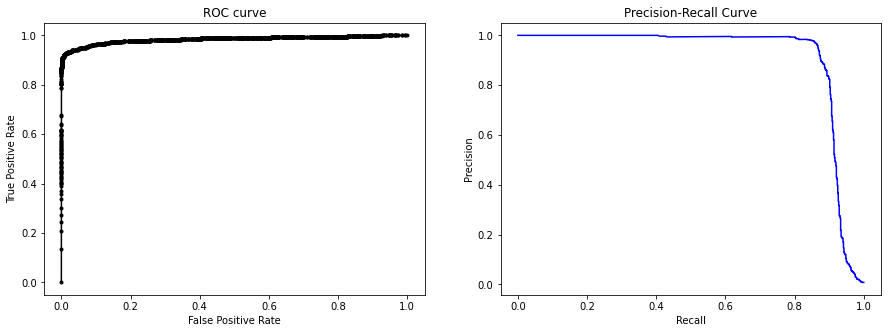

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

precision, recall, threshold = precision_recall_curve(y_true=real, probas_pred=probas)
fpr, tpr, threshold = roc_curve(y_true=real, y_score=probas)

ax1.plot(fpr, tpr, marker=".", color="k")

ax1.set_title("ROC curve")
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(recall, precision, color="b")

ax2.set_title("Precision-Recall Curve")
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")
plt.show()

## Повторное обучение: обучаем меньше эпох

In [36]:
lstm = LSTMclassifier()
_ = lstm.to(device)

In [37]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [38]:
writer_2 = SummaryWriter(log_dir="board_loss/experiment_2")
call_2 = Callback(writer_2, dataset_test, loss_function)

In [39]:
trainer(
    count_of_epoch=4,
    batch_size=64,
    dataset=dataset_train,
    model=lstm,
    loss_function=loss_function,
    optimizer=optimizer,
    lr=0.001,
    callback=call_2,
)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

Сохранение весов

In [40]:
# with open("../../weights/LSTM/lstm_4_epochs", "wb") as fp:
#     torch.save(model.state_dict(), fp)

Загрузка весов

In [ ]:
with open("../../weights/LSTM/lstm_4_epochs", "rb") as f:
    state_dict = torch.load(f, map_location=torch.device("cpu"))
model.load_state_dict(state_dict, strict=False)
model.to(device)

## Качество после обучения

In [41]:
probas = []
pred = []
real = []

lstm.eval()
for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        output = lstm(x_batch)

    # Get probability for class 1
    prob_pred = torch.softmax(output, dim=-1)[:, 1]
    probas.extend(prob_pred.to("cpu").numpy().tolist())
    # Get predicted label
    pred.extend(torch.argmax(output, dim=-1).to("cpu").numpy().tolist())
    # Ground-truth labels
    real.extend(y_batch.to("cpu").numpy().tolist())

print(classification_report(real, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.94      0.84      0.88       732

    accuracy                           1.00     99564
   macro avg       0.97      0.92      0.94     99564
weighted avg       1.00      1.00      1.00     99564



In [42]:
auc = roc_auc_score(y_true=real, y_score=probas)
print(f"AUC score: {auc:0.3f}")

AUC score: 0.980


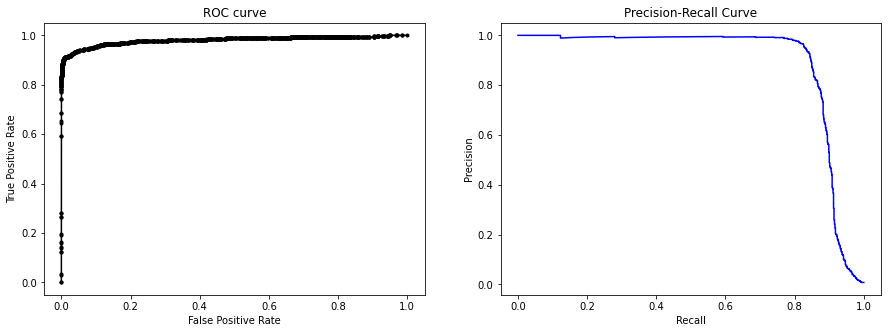

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

precision, recall, threshold = precision_recall_curve(y_true=real, probas_pred=probas)
fpr, tpr, threshold = roc_curve(y_true=real, y_score=probas)

ax1.plot(fpr, tpr, marker=".", color="k")

ax1.set_title("ROC curve")
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(recall, precision, color="b")

ax2.set_title("Precision-Recall Curve")
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")
plt.show()

Разница в метриках незначительная, когда в эпохах в ~ 3 раза.

## Инференс модели

In [72]:
def eval(model, tokenizer, first_names, second_names):

    data = [item[0] + " " + item[1] for item in list(zip(first_names, second_names))]
    tok_sents = tokenizer(data)

    with torch.no_grad():
        model.eval()
        output = model(tok_sents.to(device))
        pred_labels = torch.argmax(output, dim=-1).to("cpu").numpy().tolist()

        show = pd.DataFrame(
            list(zip(first_names, second_names)), columns=["name_1", "name_2"]
        )
        show["is_duplicate"] = pred_labels
    return show

In [73]:
first_names = ["BIT-MAT PRODUCTS", "Smmit & Co agency"]
second_names = ["Technocraft Industries (India) Ltd.", "Hermit Co."]

eval(model, tokenizer, first_names, second_names)

,name_1,name_2,is_duplicate
0,BIT-MAT PRODUCTS,Technocraft Industries (India) Ltd.,1
1,Smmit & Co agency,Hermit Co.,0


# Токенизация

## Подход № 2

Will be updated soon...